# Most optimal skills to learn for Data Analysis

In [22]:
# Load the dataset (CSV or DataFrame)
import ast
import pandas as pd
import seaborn as sns
from datasets import load_dataset
import matplotlib.pyplot as plt  

# Loading Data
dataset = load_dataset('lukebarousse/data_jobs')
df = dataset['train'].to_pandas()

# Data Cleanup
df['job_posted_date'] = pd.to_datetime(df['job_posted_date'])
df['job_skills'] = df['job_skills'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else x)


In [37]:
# Step 1: Filter the dataset for US and Data Analyst roles
df_US_DA = df[(df['job_country'] == 'United States') & (df['job_title_short'] == 'Data Analyst')].copy()

# Step 2: Explode the job_skills column so each skill has its own row
df_US_DA_exploded = df_US_DA.explode('job_skills')

# Step 3: Identify top 12 most frequent skills (before removing salary NAs)
list_top_skills = df_US_DA_exploded['job_skills'].value_counts().head(12).index.tolist()

# Step 4: Filter to keep only those top 12 skills
df_US_DA_top_skills = df_US_DA_exploded[df_US_DA_exploded['job_skills'].isin(list_top_skills)]

# Step 5: Remove rows where salary is missing
df_US_DA_top_skills = df_US_DA_top_skills[df_US_DA_top_skills['salary_year_avg'].notna()]

# Step 6: Group by skill to compute:
# - median salary
# - percentage of jobs requiring that skill (count of that skill / total jobs)
skill_stats = (
    df_US_DA_top_skills
    .groupby('job_skills')
    .agg(
        median_salary=('salary_year_avg', 'median'),
        job_postings=('job_skills', 'count')
    )
    .reset_index()
)

# Step 7: Calculate total number of job postings to get % of jobs with each skill
total_jobs = len(df_US_DA.dropna(subset=['salary_year_avg']))
skill_stats['percentage_of_jobs'] = (skill_stats['job_postings'] / total_jobs * 100).round(1)
skill_stats.sort_values(by='job_postings', ascending=False, inplace=True)
skill_stats



,job_skills,median_salary,job_postings,percentage_of_jobs
8,sql,91000.00,2508,57.7
0,excel,84392.00,1808,41.6
5,python,97500.00,1431,32.9
10,tableau,92875.00,1364,31.4
7,sas,90000.00,926,21.3
6,r,92500.00,893,20.5
3,power bi,90000.00,838,19.3
4,powerpoint,85000.00,462,10.6
11,word,81194.75,461,10.6
9,sql server,92500.00,286,6.6


/var/folders/br/42nb5mtj2d7d1fqq286wvwtr0000gp/T/ipykernel_93118/747796604.py:38: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend().remove()  # Remove legend


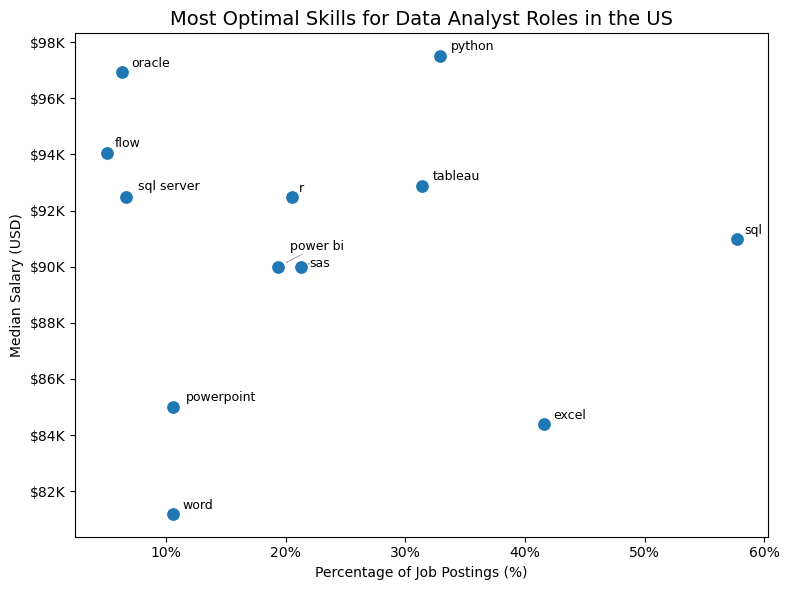

In [48]:
from adjustText import adjust_text  # Make sure this is installed: pip install adjustText

plt.figure(figsize=(8, 6))

# Scatter plot with default color (no hue)
sns.scatterplot(
    data=skill_stats,
    x='percentage_of_jobs',
    y='median_salary',
    s=100
)

# Add annotations using adjust_text with arrows
texts = []
offset_x = 0.5  # adjust based on your x-axis scale
offset_y = 100  # adjust based on your y-axis (salary scale)
for _, row in skill_stats.iterrows():
    texts.append(
        plt.text(
            row['percentage_of_jobs'] + offset_x,
            row['median_salary'] + offset_y,
            row['job_skills'], 
            fontsize=9
        )
    )

adjust_text(
    texts,
    arrowprops=dict(arrowstyle='->', color='gray', lw=0.5)
)

# Final formatting
plt.title('Most Optimal Skills for Data Analyst Roles in the US', fontsize=14)
plt.xlabel('Percentage of Job Postings (%)')
plt.ylabel('Median Salary (USD)')
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}%'))
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${int(x / 1000)}K'))
plt.legend().remove()  # Remove legend
plt.tight_layout()
plt.show()

## Bonus by coloring the skill based on technology category

In [ ]:
df_technology = df['job_type_skills'].copy()

# remove duplicates
df_technology = df_technology.drop_duplicates()

# remove NaN values
df_technology = df_technology.dropna()

# combine all dictionaries into one
technology_dict = {}
for row in df_technology:
    row_dict = ast.literal_eval(row)  # convert string to dictionary
    for key, value in row_dict.items():
        if key in technology_dict:  # if key already exists in technology_dict, add value to existing value
            technology_dict[key] += value
        else:                       # if key does not exist in technology_dict, add key and value
            technology_dict[key] = value

# remove duplicates by converting values to set then back to list
for key, value in technology_dict.items():
    technology_dict[key] = list(set(value))

technology_dict

In [50]:
# turn dictionary into dataframe
df_technology = pd.DataFrame(list(technology_dict.items()), columns=['technology', 'skills'])

df_technology = df_technology.explode('skills')

df_technology

,technology,skills
0,analyst_tools,visio
0,analyst_tools,powerpoint
0,analyst_tools,outlook
0,analyst_tools,msaccess
0,analyst_tools,alteryx
...,...,...
9,sync,wire
9,sync,webex
9,sync,mattermost
9,sync,unify


In [53]:
# merge skill_stats and df_technology
skill_stats = skill_stats.merge(df_technology, left_on='job_skills', right_on='skills')

skill_stats

,job_skills,median_salary,job_postings,percentage_of_jobs,technology,skills
0,sql,91000.00,2508,57.7,programming,sql
1,excel,84392.00,1808,41.6,analyst_tools,excel
2,python,97500.00,1431,32.9,programming,python
3,tableau,92875.00,1364,31.4,analyst_tools,tableau
4,sas,90000.00,926,21.3,analyst_tools,sas
5,sas,90000.00,926,21.3,programming,sas
6,r,92500.00,893,20.5,programming,r
7,power bi,90000.00,838,19.3,analyst_tools,power bi
8,powerpoint,85000.00,462,10.6,analyst_tools,powerpoint
9,word,81194.75,461,10.6,analyst_tools,word


4 [-0.48312736  0.29701848]
5 [ 0.3023284 -0.3761081]


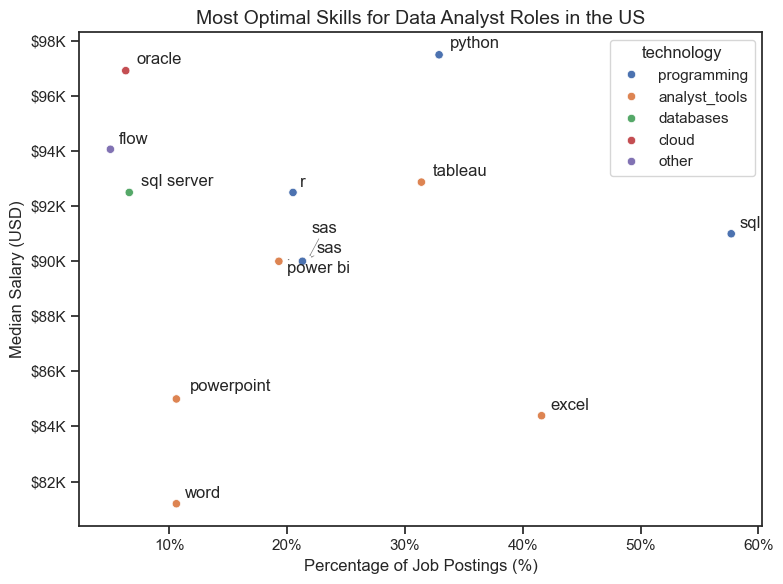

In [58]:
from adjustText import adjust_text  # Make sure this is installed: pip install adjustText

plt.figure(figsize=(8, 6))

# Scatter plot with default color (no hue)
sns.scatterplot(
    data=skill_stats,
    x='percentage_of_jobs',
    y='median_salary',
    hue='technology'
)
sns.set_theme(style='ticks')

# Add annotations using adjust_text with arrows
texts = []
offset_x = 0.5  # adjust based on your x-axis scale
offset_y = 100  # adjust based on your y-axis (salary scale)
for _, row in skill_stats.iterrows():
    texts.append(
        plt.text(
            row['percentage_of_jobs'] + offset_x,
            row['median_salary'] + offset_y,
            row['job_skills'], 
            fontsize=12
        )
    )

adjust_text(
    texts,
    arrowprops=dict(arrowstyle='->', color='gray', lw=0.5)
)

# Final formatting
plt.title('Most Optimal Skills for Data Analyst Roles in the US', fontsize=14)
plt.xlabel('Percentage of Job Postings (%)')
plt.ylabel('Median Salary (USD)')
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}%'))
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${int(x / 1000)}K'))
plt.tight_layout()
plt.show()